# Projeto disciplina IA367


## Geração de cenários em sistemas de distribuição usando modelos generativos

### Integrantes: 


*  Hernán Ullón         
*  Karen Rosero
*  Luis Henrique Tenório







# Bibliotecas

In [ ]:
import tensorflow as tf
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import os
import numpy as np
from numpy import genfromtxt
from sklearn.model_selection import train_test_split

# 1. Declaração dos dados para cada transformador

Por enquanto, selecionamos os transformadores com melhor comportamento, os medidores 0, 1, 2, 4, 5

In [ ]:
_dir = "/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/banco de dados v5"

transf_ok = sorted(os.listdir(_dir))

#Transformador 0
data_0 = genfromtxt(os.path.join(_dir, transf_ok[0]), delimiter=',')
data_0 = data_0[1:,1:]     
print("Transformador 0", data_0.shape)   
# separo em treino e teste com o 80% dos dados para treinamento e o 20% para validação
x0_train = data_0[:int(np.rint(data_0.shape[0]*0.8))]
x0_test = data_0[int(np.rint(data_0.shape[0]*0.8)):]
print('Amostras de treinamento: ', len(x0_train))
print('Amostras de teste: ', len(x0_test))

#Transformador 1
data_1 = genfromtxt(os.path.join(_dir, transf_ok[1]), delimiter=',')
data_1 = data_1[1:,1:]     
print("Transformador 1", data_1.shape)   
# separo em treino e teste com o 80% dos dados para treinamento e o 20% para validação
x1_train = data_1[:int(np.rint(data_1.shape[0]*0.8))]
x1_test = data_1[int(np.rint(data_1.shape[0]*0.8)):]
print('Amostras de treinamento: ', len(x1_train))
print('Amostras de teste: ', len(x1_test))

#Transformador 2
data_2 = genfromtxt(os.path.join(_dir, transf_ok[2]), delimiter=',')
data_2 = data_2[1:,1:]     
print("Transformador 2", data_2.shape)  
x2_train = data_2[:int(np.rint(data_2.shape[0]*0.8))]
x2_test = data_2[int(np.rint(data_2.shape[0]*0.8)):]
print('Amostras de treinamento: ', len(x2_train))
print('Amostras de teste: ', len(x2_test))

#Transformador 3
data_3 = genfromtxt(os.path.join(_dir, transf_ok[3]), delimiter=',')
data_3 = data_3[1:,1:]     
print("Transformador 3", data_3.shape)  
x3_train = data_3[:int(np.rint(data_3.shape[0]*0.8))]
x3_test = data_3[int(np.rint(data_3.shape[0]*0.8)):]
print('Amostras de treinamento: ', len(x3_train))
print('Amostras de teste: ', len(x3_test))

#Transformador 4
data_4 = genfromtxt(os.path.join(_dir, transf_ok[4]), delimiter=',')
data_4 = data_4[1:,1:]     
print("Transformador 4", data_4.shape)  
x4_train = data_4[:int(np.rint(data_4.shape[0]*0.8))]
x4_test = data_4[int(np.rint(data_4.shape[0]*0.8)):]
print('Amostras de treinamento: ', len(x4_train))
print('Amostras de teste: ', len(x4_test))

#Transformador 5
data_5 = genfromtxt(os.path.join(_dir, transf_ok[5]), delimiter=',')
data_5 = data_5[1:,1:]     
print("Transformador 5", data_5.shape) 
x5_train = data_5[:int(np.rint(data_5.shape[0]*0.8))]
x5_test = data_5[int(np.rint(data_5.shape[0]*0.8)):] 
print('Amostras de treinamento: ', len(x5_train))
print('Amostras de teste: ', len(x5_test))

Transformador 0 (9737, 96)
Amostras de treinamento:  7790
Amostras de teste:  1947
Transformador 1 (9731, 96)
Amostras de treinamento:  7785
Amostras de teste:  1946
Transformador 2 (8646, 96)
Amostras de treinamento:  6917
Amostras de teste:  1729
Transformador 3 (1593, 96)
Amostras de treinamento:  1274
Amostras de teste:  319
Transformador 4 (2883, 96)
Amostras de treinamento:  2306
Amostras de teste:  577
Transformador 5 (929, 96)
Amostras de treinamento:  743
Amostras de teste:  186


In [ ]:
# Todos os transformadores concatenados 
total = np.vstack((data_0, data_1, data_2, data_3, data_4, data_5))
np.random.shuffle(total)
X_train = total[:int(np.rint(total.shape[0]*0.7))]
X_test = total[int(np.rint(total.shape[0]*0.7)):]
print("Transformadores concatenados", total.shape)  
print("Transformadores concatenados", total.shape)  
print("Transformadores concatenados", total.shape)  

Transformadores concatenados (33519, 96)


# 2. Classes e funções do modelo NICE

In [ ]:
class Shuffle(Layer):
    #A camada de embaralhamento fornece duas maneiras de embaralhar a dimensão de entrada:
    #Um é inversão direta, o outro é aleatório, o padrão é inverter diretamente a dimensão
    
    def __init__(self, idxs=None, mode='reverse', **kwargs):
        super(Shuffle, self).__init__(**kwargs)
        self.idxs = idxs
        self.mode = mode
    def call(self, inputs):
        v_dim = K.int_shape(inputs)[-1]
        if self.idxs == None:
            self.idxs = list(range(v_dim))
            if self.mode == 'reverse':
                self.idxs = self.idxs[::-1]
            elif self.mode == 'random':
                np.random.shuffle(self.idxs)
        inputs = K.transpose(inputs)
        outputs = K.gather(inputs, self.idxs)
        outputs = K.transpose(outputs)
        return outputs
    def inverse(self):
        v_dim = len(self.idxs)
        _ = sorted(zip(range(v_dim), self.idxs), key=lambda s: s[1])
        reverse_idxs = [i[0] for i in _]
        return Shuffle(reverse_idxs)


class SplitVector(Layer):
    #Particionar a entrada em duas partes, intercalar as partições
    def __init__(self, **kwargs):
        super(SplitVector, self).__init__(**kwargs)
    def call(self, inputs):
        v_dim = K.int_shape(inputs)[-1]
        inputs = K.reshape(inputs, (-1, v_dim//2, 2))
        return [inputs[:,:,0], inputs[:,:,1]]
    def compute_output_shape(self, input_shape):
        v_dim = input_shape[-1]
        return [(None, v_dim//2), (None, v_dim//2)]
    def inverse(self):
        layer = ConcatVector()
        return layer

class ConcatVector(Layer):
    #Mescle novamente as duas partes da partição
    def __init__(self, **kwargs):
        super(ConcatVector, self).__init__(**kwargs)
    def call(self, inputs):
        inputs = [K.expand_dims(i, 2) for i in inputs]
        inputs = K.concatenate(inputs, 2)
        return K.reshape(inputs, (-1, np.prod(K.int_shape(inputs)[1:])))
    def compute_output_shape(self, input_shape):
        return (None, sum([i[-1] for i in input_shape]))
    def inverse(self):
        layer = SplitVector()
        return layer


class AddCouple(Layer):
    #camada de acoplamento aditivo
    def __init__(self, isinverse=False, **kwargs):
        self.isinverse = isinverse
        super(AddCouple, self).__init__(**kwargs)
    def call(self, inputs):
        part1, part2, mpart1 = inputs
        if self.isinverse:
            return [part1, part2 + mpart1] # 逆为加 inverso para mais
        else:
            return [part1, part2 - mpart1] # 正为减 positivo para menos
    def compute_output_shape(self, input_shape): 
        return [input_shape[0], input_shape[1]]
    def inverse(self):
        layer = AddCouple(True)
        return layer


class Scale(Layer):
    # camada de escalamento
    def __init__(self, **kwargs):
        super(Scale, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, input_shape[1]),
                                      initializer='glorot_normal',
                                      trainable=True)
    def call(self, inputs):
        self.add_loss(-K.sum(self.kernel)) # 对数行列式 determinante logaritmico
        return K.exp(self.kernel) * inputs
    def inverse(self):
        scale = K.exp(-self.kernel)
        return Lambda(lambda x: scale * x)


def build_basic_model(v_dim):
    #O modelo base, ou seja, m na camada de acoplamento aditivo
    _in = Input(shape=(v_dim,))
    _ = _in
    for i in range(5):
        _ = Dense(500, activation='relu')(_)
    _ = Dense(v_dim, activation='relu')(_)
    return Model(_in, _)



# 3. Gerando curvas para cada transformador por separado

## 3.1. Transformador 0

Instancias encoder

In [ ]:
shuffle1 = Shuffle()
shuffle2 = Shuffle()
shuffle3 = Shuffle()
shuffle4 = Shuffle()

split = SplitVector()
couple = AddCouple()
concat = ConcatVector()
scale = Scale()

original_dim = 96

basic_model_1 = build_basic_model(original_dim//2)
basic_model_2 = build_basic_model(original_dim//2)
basic_model_3 = build_basic_model(original_dim//2)
basic_model_4 = build_basic_model(original_dim//2)


x_in = Input(shape=(original_dim,))
x = x_in


# Adicione ruído negativo à entrada

x = Lambda(lambda s: K.in_train_phase(s-0.01*K.random_uniform(K.shape(s)), s))(x)

x = shuffle1(x)
x1,x2 = split(x)
mx1 = basic_model_1(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle2(x)
x1,x2 = split(x)
mx1 = basic_model_2(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle3(x)
x1,x2 = split(x)
mx1 = basic_model_3(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle4(x)
x1,x2 = split(x)
mx1 = basic_model_4(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = scale(x)

In [ ]:
encoder0 = Model(x_in, x)
encoder0.summary()
encoder0.compile(loss=lambda y_true, y_pred: K.sum(0.5 * y_pred**2, 1),
                optimizer='adam')

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 96)           0           input_10[0][0]                   
__________________________________________________________________________________________________
shuffle_4 (Shuffle)             (None, 96)           0           lambda_1[0][0]                   
__________________________________________________________________________________________________
split_vector_1 (SplitVector)    [(None, 48), (None,  0           shuffle_4[0][0]                  
                                                                 shuffle_5[0][0]            

Treinamento do encoder

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf0.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history0 = encoder0.fit(x0_train,
            x0_train,
            batch_size=128,
            epochs=100,
            validation_data=(x0_test, x0_test), callbacks=[model_checkpoint_callback, early_stop_callback])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_9/shuffle_7/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_9/shuffle_7/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_9/shuffle_7/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_9/shuffle_6/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_9/shuffle_6/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_9/shuffle_6/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of

61/61 [==============================] - 6s 24ms/step - loss: -2.3305 - val_loss: -5.9848
Epoch 2/100
61/61 [==============================] - 1s 16ms/step - loss: -8.8662 - val_loss: -11.9696
Epoch 3/100
61/61 [==============================] - 1s 17ms/step - loss: -14.7628 - val_loss: -17.8203
Epoch 4/100
61/61 [==============================] - 1s 16ms/step - loss: -20.6119 - val_loss: -23.8011
Epoch 5/100
61/61 [==============================] - 1s 14ms/step - loss: -26.7274 - val_loss: -29.6838
Epoch 6/100
61/61 [==============================] - 1s 17ms/step - loss: -32.5923 - val_loss: -35.1529
Epoch 7/100
61/61 [==============================] - 1s 15ms/step - loss: -36.8700 - val_loss: -40.8243
Epoch 8/100
61/61 [==============================] - 1s 13ms/step - loss: -44.0916 - val_loss: -47.0288
Epoch 9/100
61/61 [==============================] - 1s 12ms/step - loss: -50.1487 - val_loss: -52.9204
Epoch 10/100
61/61 [==============================] - 1s 17ms/step - loss: -56.

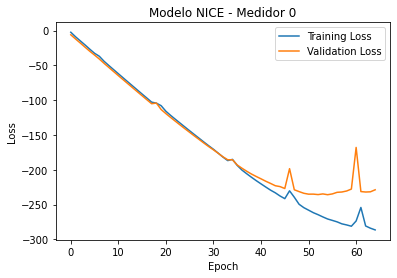

In [ ]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history0.history['loss']
val_accuracy = history0.history['val_loss']
np.save("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf0_history.npy", np.concatenate((train_accuracy,val_accuracy), axis = 0))
# Set figure size.
plt.figure()
# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Loss')
plt.plot(val_accuracy, label='Validation Loss')
# Set title
plt.title('Modelo NICE - Medidor 0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf0.png", dpi=300)

Instancias decoder

In [ ]:
# Construir o modelo inverso (gerar o modelo) e realizar todas as operações 
# no sentido inverso

x = x_in
x = scale.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_4(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle4.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_3(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle3.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_2(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle2.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_1(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle1.inverse()(x)

decoder0 = Model(x_in, x)

Geração de 40% de amostras novas em relação ao número original de amostras

In [ ]:
n_amostras = int(x0_train.shape[0]*0.4)
output_size = 96
samples_x0 = np.zeros((n_amostras, 96))

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      samples_x0[i,:] = decoder0.predict(z_sample)

np.savetxt("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/new_transf0_40p.csv", samples_x0, delimiter=",")

Geração do número de amostras precisas para atingir 15000 amostras em total

In [ ]:
n_amostras = 15000-x0_train.shape[0]
output_size = 96
samples_x0 = np.zeros((n_amostras, 96))

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      samples_x0[i,:] = decoder0.predict(z_sample)

np.savetxt("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/new_transf0_15k.csv", samples_x0, delimiter=",")

## 3.2. Transformador 1

Instancias encoder

In [ ]:
shuffle1 = Shuffle()
shuffle2 = Shuffle()
shuffle3 = Shuffle()
shuffle4 = Shuffle()

split = SplitVector()
couple = AddCouple()
concat = ConcatVector()
scale = Scale()

original_dim = 96

basic_model_1 = build_basic_model(original_dim//2)
basic_model_2 = build_basic_model(original_dim//2)
basic_model_3 = build_basic_model(original_dim//2)
basic_model_4 = build_basic_model(original_dim//2)


x_in = Input(shape=(original_dim,))
x = x_in


# Adicione ruído negativo à entrada

x = Lambda(lambda s: K.in_train_phase(s-0.01*K.random_uniform(K.shape(s)), s))(x)

x = shuffle1(x)
x1,x2 = split(x)
mx1 = basic_model_1(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle2(x)
x1,x2 = split(x)
mx1 = basic_model_2(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle3(x)
x1,x2 = split(x)
mx1 = basic_model_3(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle4(x)
x1,x2 = split(x)
mx1 = basic_model_4(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = scale(x)

In [ ]:
encoder1 = Model(x_in, x)
encoder1.summary()
encoder1.compile(loss=lambda y_true, y_pred: K.sum(0.5 * y_pred**2, 1),
                optimizer='adam')

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 96)           0           input_15[0][0]                   
__________________________________________________________________________________________________
shuffle_12 (Shuffle)            (None, 96)           0           lambda_3[0][0]                   
__________________________________________________________________________________________________
split_vector_6 (SplitVector)    [(None, 48), (None,  0           shuffle_12[0][0]                 
                                                                 shuffle_13[0][0]          

Treinamento do encoder

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf1.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history1 = encoder1.fit(x1_train,
            x1_train,
            batch_size=128,
            epochs=400,
            validation_data=(x1_test, x1_test), callbacks=[model_checkpoint_callback, early_stop_callback])

Epoch 1/400


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_15/shuffle_15/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_15/shuffle_15/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_15/shuffle_15/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_15/shuffle_14/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_15/shuffle_14/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_15/shuffle_14/Cast:0", shape=(2,), dtype=int32))) to a den

61/61 [==============================] - 3s 20ms/step - loss: -0.4893 - val_loss: -3.7707
Epoch 2/400
61/61 [==============================] - 1s 9ms/step - loss: -6.6605 - val_loss: -9.6253
Epoch 3/400
61/61 [==============================] - 1s 9ms/step - loss: -12.5868 - val_loss: -15.6209
Epoch 4/400
61/61 [==============================] - 1s 9ms/step - loss: -18.4778 - val_loss: -21.4806
Epoch 5/400
61/61 [==============================] - 1s 8ms/step - loss: -24.3511 - val_loss: -27.3703
Epoch 6/400
61/61 [==============================] - 1s 13ms/step - loss: -30.2289 - val_loss: -33.2249
Epoch 7/400
61/61 [==============================] - 1s 13ms/step - loss: -35.2882 - val_loss: -38.0073
Epoch 8/400
61/61 [==============================] - 1s 12ms/step - loss: -41.4773 - val_loss: -44.6486
Epoch 9/400
61/61 [==============================] - 0s 8ms/step - loss: -47.5066 - val_loss: -50.5511
Epoch 10/400
61/61 [==============================] - 0s 8ms/step - loss: -53.3680 - 

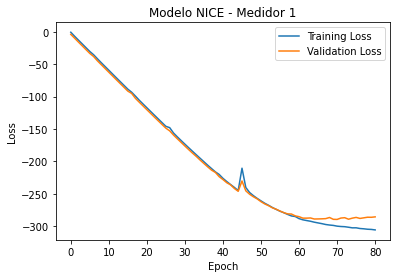

In [ ]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history1.history['loss']
val_accuracy = history1.history['val_loss']
np.save("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf1_history.npy", np.concatenate((train_accuracy,val_accuracy), axis = 0))
# Set figure size.
plt.figure()
# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Loss')
plt.plot(val_accuracy, label='Validation Loss')
# Set title
plt.title('Modelo NICE - Medidor 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf1.png", dpi=300)

Instancias decoder

In [ ]:
# Construir o modelo inverso (gerar o modelo) e realizar todas as operações 
# no sentido inverso

x = x_in
x = scale.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_4(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle4.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_3(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle3.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_2(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle2.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_1(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle1.inverse()(x)

decoder1 = Model(x_in, x)

Geração de amostras novas 

In [ ]:
n_amostras = int(x1_train.shape[0]*0.4)
output_size = 96
samples_x1 = np.zeros((n_amostras, 96))

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      samples_x1[i,:] = decoder1.predict(z_sample)

np.savetxt("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/new_transf1_40p.csv", samples_x1, delimiter=",")

Geração do número de amostras precisas para atingir 12000 amostras em total

In [ ]:
n_amostras = 15000-x1_train.shape[0]
output_size = 96
samples_x1 = np.zeros((n_amostras, 96))

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      samples_x1[i,:] = decoder1.predict(z_sample)

np.savetxt("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/new_transf1_15k.csv", samples_x1, delimiter=",")

## 3.3. Transformador 2

Instancias encoder

In [ ]:
shuffle1 = Shuffle()
shuffle2 = Shuffle()
shuffle3 = Shuffle()
shuffle4 = Shuffle()

split = SplitVector()
couple = AddCouple()
concat = ConcatVector()
scale = Scale()

original_dim = 96

basic_model_1 = build_basic_model(original_dim//2)
basic_model_2 = build_basic_model(original_dim//2)
basic_model_3 = build_basic_model(original_dim//2)
basic_model_4 = build_basic_model(original_dim//2)


x_in = Input(shape=(original_dim,))
x = x_in


# Adicione ruído negativo à entrada

x = Lambda(lambda s: K.in_train_phase(s-0.01*K.random_uniform(K.shape(s)), s))(x)

x = shuffle1(x)
x1,x2 = split(x)
mx1 = basic_model_1(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle2(x)
x1,x2 = split(x)
mx1 = basic_model_2(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle3(x)
x1,x2 = split(x)
mx1 = basic_model_3(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle4(x)
x1,x2 = split(x)
mx1 = basic_model_4(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = scale(x)

In [ ]:
encoder2 = Model(x_in, x)
encoder2.summary()
encoder2.compile(loss=lambda y_true, y_pred: K.sum(0.5 * y_pred**2, 1),
                optimizer='adam')

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 96)           0           input_20[0][0]                   
__________________________________________________________________________________________________
shuffle_20 (Shuffle)            (None, 96)           0           lambda_5[0][0]                   
__________________________________________________________________________________________________
split_vector_11 (SplitVector)   [(None, 48), (None,  0           shuffle_20[0][0]                 
                                                                 shuffle_21[0][0]          

Treinamento do encoder

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf2.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history2 = encoder2.fit(x2_train,
            x2_train,
            batch_size=128,
            epochs=200,
            validation_data=(x2_test, x2_test), callbacks=[model_checkpoint_callback, early_stop_callback])

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_21/shuffle_23/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_21/shuffle_23/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_21/shuffle_23/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_21/shuffle_22/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_21/shuffle_22/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_21/shuffle_22/Cast:0", shape=(2,), dtype=int32))) to a den

55/55 [==============================] - 4s 29ms/step - loss: -1.4632 - val_loss: -4.7947
Epoch 2/200
55/55 [==============================] - 0s 9ms/step - loss: -7.6471 - val_loss: -10.5285
Epoch 3/200
55/55 [==============================] - 0s 8ms/step - loss: -13.5480 - val_loss: -16.3122
Epoch 4/200
55/55 [==============================] - 1s 9ms/step - loss: -18.8299 - val_loss: -21.5997
Epoch 5/200
55/55 [==============================] - 0s 8ms/step - loss: -24.2589 - val_loss: -26.9183
Epoch 6/200
55/55 [==============================] - 0s 8ms/step - loss: -29.5304 - val_loss: -32.1813
Epoch 7/200
55/55 [==============================] - 0s 9ms/step - loss: -34.7526 - val_loss: -37.3244
Epoch 8/200
55/55 [==============================] - 0s 9ms/step - loss: -39.9787 - val_loss: -42.6015
Epoch 9/200
55/55 [==============================] - 1s 9ms/step - loss: -45.0826 - val_loss: -47.7896
Epoch 10/200
55/55 [==============================] - 0s 9ms/step - loss: -50.4000 - va

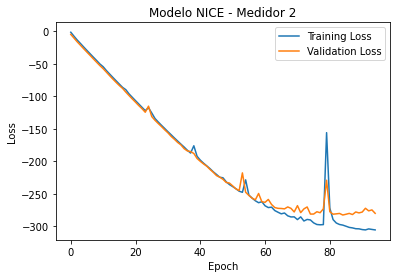

In [ ]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history2.history['loss']
val_accuracy = history2.history['val_loss']
np.save("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf2_history.npy", np.concatenate((train_accuracy,val_accuracy), axis = 0))
# Set figure size.
plt.figure()
# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Loss')
plt.plot(val_accuracy, label='Validation Loss')
# Set title
plt.title('Modelo NICE - Medidor 2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf2.png", dpi=300)

Instancias decoder

In [ ]:
# Construir o modelo inverso (gerar o modelo) e realizar todas as operações 
# no sentido inverso

x = x_in
x = scale.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_4(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle4.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_3(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle3.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_2(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle2.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_1(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle1.inverse()(x)

decoder2 = Model(x_in, x)

Geração de amostras novas 

In [ ]:
n_amostras = int(x2_train.shape[0]*0.4)
output_size = 96
samples_x2 = np.zeros((n_amostras, 96))

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      samples_x2[i,:] = decoder2.predict(z_sample)

np.savetxt("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/new_transf2_40p.csv", samples_x2, delimiter=",")

Geração do número de amostras precisas para atingir 12000 amostras em total

In [ ]:
n_amostras = 15000-x2_train.shape[0]
output_size = 96
samples_x2 = np.zeros((n_amostras, 96))

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      samples_x2[i,:] = decoder2.predict(z_sample)

np.savetxt("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/new_transf2_15k.csv", samples_x2, delimiter=",")

## 3.3. Transformador 3

Instancias encoder

In [ ]:
shuffle1 = Shuffle()
shuffle2 = Shuffle()
shuffle3 = Shuffle()
shuffle4 = Shuffle()

split = SplitVector()
couple = AddCouple()
concat = ConcatVector()
scale = Scale()

original_dim = 96

basic_model_1 = build_basic_model(original_dim//2)
basic_model_2 = build_basic_model(original_dim//2)
basic_model_3 = build_basic_model(original_dim//2)
basic_model_4 = build_basic_model(original_dim//2)


x_in = Input(shape=(original_dim,))
x = x_in


# Adicione ruído negativo à entrada

x = Lambda(lambda s: K.in_train_phase(s-0.01*K.random_uniform(K.shape(s)), s))(x)

x = shuffle1(x)
x1,x2 = split(x)
mx1 = basic_model_1(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle2(x)
x1,x2 = split(x)
mx1 = basic_model_2(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle3(x)
x1,x2 = split(x)
mx1 = basic_model_3(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle4(x)
x1,x2 = split(x)
mx1 = basic_model_4(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = scale(x)

In [ ]:
encoder3 = Model(x_in, x)
encoder3.summary()
encoder3.compile(loss=lambda y_true, y_pred: K.sum(0.5 * y_pred**2, 1),
                optimizer='adam')

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 96)           0           input_40[0][0]                   
__________________________________________________________________________________________________
shuffle_28 (Shuffle)            (None, 96)           0           lambda_7[0][0]                   
__________________________________________________________________________________________________
split_vector_7 (SplitVector)    [(None, 48), (None,  0           shuffle_28[0][0]                 
                                                                 shuffle_29[0][0]          

Treinamento do encoder

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf3v2.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

history3 = encoder3.fit(x3_train,
            x3_train,
            batch_size=100,
            epochs=500,
            validation_data=(x3_test, x3_test), callbacks=[model_checkpoint_callback, early_stop_callback])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_41/shuffle_31/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_41/shuffle_31/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_41/shuffle_31/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_41/shuffle_30/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_41/shuffle_30/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_41/shuffle_30/Cast:0", shape=(2,), dtype=int32))) to a den

13/13 [==============================] - 51s 36ms/step - loss: 3.8191 - val_loss: 0.8461
Epoch 2/500
13/13 [==============================] - 0s 11ms/step - loss: 0.6167 - val_loss: -0.5695
Epoch 3/500
13/13 [==============================] - 0s 11ms/step - loss: -0.8701 - val_loss: -1.9492
Epoch 4/500
13/13 [==============================] - 0s 10ms/step - loss: -2.1663 - val_loss: -3.2365
Epoch 5/500
13/13 [==============================] - 0s 10ms/step - loss: -3.4259 - val_loss: -4.4854
Epoch 6/500
13/13 [==============================] - 0s 10ms/step - loss: -4.6770 - val_loss: -5.7434
Epoch 7/500
13/13 [==============================] - 0s 11ms/step - loss: -5.9190 - val_loss: -6.9971
Epoch 8/500
13/13 [==============================] - 0s 10ms/step - loss: -7.1571 - val_loss: -8.2387
Epoch 9/500
13/13 [==============================] - 0s 10ms/step - loss: -8.3896 - val_loss: -9.4823
Epoch 10/500
13/13 [==============================] - 0s 18ms/step - loss: -9.6228 - val_loss: -

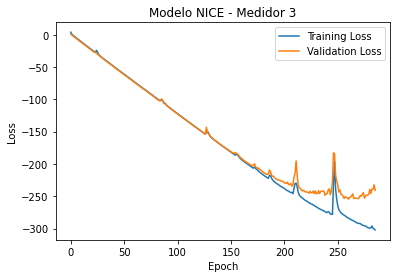

In [ ]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history3.history['loss']
val_accuracy = history3.history['val_loss']
np.save("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf3v2_history.npy", np.concatenate((train_accuracy,val_accuracy), axis = 0))
# Set figure size.
plt.figure()
# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Loss')
plt.plot(val_accuracy, label='Validation Loss')
# Set title
plt.title('Modelo NICE - Medidor 3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf3v2.png", dpi=300)

Instancias decoder

In [ ]:
# Construir o modelo inverso (gerar o modelo) e realizar todas as operações 
# no sentido inverso

x = x_in
x = scale.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_4(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle4.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_3(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle3.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_2(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle2.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_1(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle1.inverse()(x)

decoder3 = Model(x_in, x)

Geração de amostras novas 

In [ ]:
n_amostras = int(x3_train.shape[0]*0.4)
output_size = 96
samples_x3 = np.zeros((n_amostras, 96))

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      samples_x3[i,:] = decoder3.predict(z_sample)

np.savetxt("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/new_transf3_40p.csv", samples_x3, delimiter=",")

Geração do número de amostras precisas para atingir 12000 amostras em total

In [ ]:
n_amostras = 15000-x3_train.shape[0]
output_size = 96
samples_x3 = np.zeros((n_amostras, 96))

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      samples_x3[i,:] = decoder3.predict(z_sample)

In [ ]:
np.savetxt("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/new_transf3_15k.csv", samples_x3, delimiter=",")

## 3.4. Transformador 4

Instancias encoder

In [ ]:
shuffle1 = Shuffle()
shuffle2 = Shuffle()
shuffle3 = Shuffle()
shuffle4 = Shuffle()

split = SplitVector()
couple = AddCouple()
concat = ConcatVector()
scale = Scale()

original_dim = 96

basic_model_1 = build_basic_model(original_dim//2)
basic_model_2 = build_basic_model(original_dim//2)
basic_model_3 = build_basic_model(original_dim//2)
basic_model_4 = build_basic_model(original_dim//2)


x_in = Input(shape=(original_dim,))
x = x_in


# Adicione ruído negativo à entrada

x = Lambda(lambda s: K.in_train_phase(s-0.01*K.random_uniform(K.shape(s)), s))(x)

x = shuffle1(x)
x1,x2 = split(x)
mx1 = basic_model_1(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle2(x)
x1,x2 = split(x)
mx1 = basic_model_2(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle3(x)
x1,x2 = split(x)
mx1 = basic_model_3(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle4(x)
x1,x2 = split(x)
mx1 = basic_model_4(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = scale(x)

In [ ]:
encoder4 = Model(x_in, x)
encoder4.summary()
encoder4.compile(loss=lambda y_true, y_pred: K.sum(0.5 * y_pred**2, 1),
                optimizer='adam')

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 96)           0           input_30[0][0]                   
__________________________________________________________________________________________________
shuffle_36 (Shuffle)            (None, 96)           0           lambda_9[0][0]                   
__________________________________________________________________________________________________
split_vector_21 (SplitVector)   [(None, 48), (None,  0           shuffle_36[0][0]                 
                                                                 shuffle_37[0][0]          

Treinamento do encoder

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf4.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history4 = encoder4.fit(x4_train,
            x4_train,
            batch_size=128,
            epochs=550,
            validation_data=(x4_test, x4_test), callbacks=[model_checkpoint_callback, early_stop_callback])

Epoch 1/550


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_33/shuffle_39/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_33/shuffle_39/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_33/shuffle_39/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_33/shuffle_38/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_33/shuffle_38/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_33/shuffle_38/Cast:0", shape=(2,), dtype=int32))) to a den

19/19 [==============================] - 3s 38ms/step - loss: 0.2414 - val_loss: -1.4316
Epoch 2/550
19/19 [==============================] - 0s 12ms/step - loss: -2.1028 - val_loss: -3.4359
Epoch 3/550
19/19 [==============================] - 0s 14ms/step - loss: -4.0986 - val_loss: -5.3044
Epoch 4/550
19/19 [==============================] - 0s 12ms/step - loss: -5.9856 - val_loss: -7.1380
Epoch 5/550
19/19 [==============================] - 0s 14ms/step - loss: -7.8672 - val_loss: -8.9786
Epoch 6/550
19/19 [==============================] - 0s 13ms/step - loss: -9.6969 - val_loss: -10.8199
Epoch 7/550
19/19 [==============================] - 0s 13ms/step - loss: -11.5392 - val_loss: -12.5875
Epoch 8/550
19/19 [==============================] - 0s 13ms/step - loss: -13.3364 - val_loss: -14.4707
Epoch 9/550
19/19 [==============================] - 0s 12ms/step - loss: -15.2574 - val_loss: -16.3994
Epoch 10/550
19/19 [==============================] - 0s 12ms/step - loss: -17.1206 - va

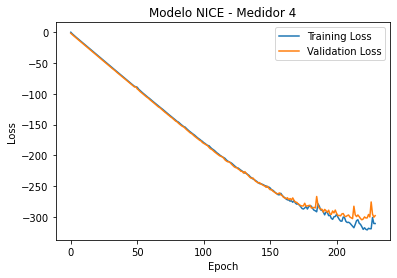

In [ ]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history4.history['loss']
val_accuracy = history4.history['val_loss']
np.save("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf4_history.npy", np.concatenate((train_accuracy,val_accuracy), axis = 0))
# Set figure size.
plt.figure()
# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Loss')
plt.plot(val_accuracy, label='Validation Loss')
# Set title
plt.title('Modelo NICE - Medidor 4')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf4.png", dpi=300)

Instancias decoder

In [ ]:
# Construir o modelo inverso (gerar o modelo) e realizar todas as operações 
# no sentido inverso

x = x_in
x = scale.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_4(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle4.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_3(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle3.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_2(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle2.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_1(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle1.inverse()(x)

decoder4 = Model(x_in, x)

Geração de amostras novas 

In [ ]:
n_amostras = int(x4_train.shape[0]*0.4)
output_size = 96
samples_x4 = np.zeros((n_amostras, 96))

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      samples_x4[i,:] = decoder4.predict(z_sample)

np.savetxt("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/new_transf4_40p.csv", samples_x4, delimiter=",")

Geração do número de amostras precisas para atingir 12000 amostras em total

In [ ]:
n_amostras = 15000-x4_train.shape[0]
output_size = 96
samples_x4 = np.zeros((n_amostras, 96))

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      samples_x4[i,:] = decoder4.predict(z_sample)

np.savetxt("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/new_transf4_15k.csv", samples_x4, delimiter=",")

## 3.5. Transformador 5

Instancias encoder

In [ ]:
shuffle1 = Shuffle()
shuffle2 = Shuffle()
shuffle3 = Shuffle()
shuffle4 = Shuffle()

split = SplitVector()
couple = AddCouple()
concat = ConcatVector()
scale = Scale()

original_dim = 96

basic_model_1 = build_basic_model(original_dim//2)
basic_model_2 = build_basic_model(original_dim//2)
basic_model_3 = build_basic_model(original_dim//2)
basic_model_4 = build_basic_model(original_dim//2)


x_in = Input(shape=(original_dim,))
x = x_in

In [ ]:
# Adicione ruído negativo à entrada
x = Lambda(lambda s: K.in_train_phase(s-0.01*K.random_uniform(K.shape(s)), s))(x)

x = shuffle1(x)
x1,x2 = split(x)
mx1 = basic_model_1(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle2(x)
x1,x2 = split(x)
mx1 = basic_model_2(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle3(x)
x1,x2 = split(x)
mx1 = basic_model_3(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle4(x)
x1,x2 = split(x)
mx1 = basic_model_4(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = scale(x)

encoder5 = Model(x_in, x)
encoder5.summary()
encoder5.compile(loss=lambda y_true, y_pred: K.sum(0.5 * y_pred**2, 1),
                optimizer='adam')

Model: "model_67"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 96)           0           input_65[0][0]                   
__________________________________________________________________________________________________
shuffle_52 (Shuffle)            (None, 96)           0           lambda_13[0][0]                  
__________________________________________________________________________________________________
split_vector_16 (SplitVector)   [(None, 48), (None,  0           shuffle_52[0][0]                 
                                                                 shuffle_53[0][0]          

Treinamento do encoder

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf5v2.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=35)

history5 = encoder5.fit(x5_train,
            x5_train,
            batch_size=64,
            epochs=600,
            validation_data=(x5_test, x5_test),  callbacks=[model_checkpoint_callback, early_stop_callback])

Epoch 1/600


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_67/shuffle_55/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_67/shuffle_55/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_67/shuffle_55/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_67/shuffle_54/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_67/shuffle_54/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_67/shuffle_54/Cast:0", shape=(2,), dtype=int32))) to a den

12/12 [==============================] - 3s 58ms/step - loss: 9.3840 - val_loss: 2.6699
Epoch 2/600
12/12 [==============================] - 0s 15ms/step - loss: 1.7090 - val_loss: 1.0390
Epoch 3/600
12/12 [==============================] - 0s 14ms/step - loss: 0.0617 - val_loss: -0.5492
Epoch 4/600
12/12 [==============================] - 0s 13ms/step - loss: -1.2601 - val_loss: -1.7738
Epoch 5/600
12/12 [==============================] - 0s 13ms/step - loss: -2.4867 - val_loss: -3.0152
Epoch 6/600
12/12 [==============================] - 0s 10ms/step - loss: -3.9611 - val_loss: -4.4881
Epoch 7/600
12/12 [==============================] - 0s 9ms/step - loss: -5.2166 - val_loss: -5.6940
Epoch 8/600
12/12 [==============================] - 0s 10ms/step - loss: -6.3872 - val_loss: -6.8460
Epoch 9/600
12/12 [==============================] - 0s 10ms/step - loss: -7.5379 - val_loss: -7.9773
Epoch 10/600
12/12 [==============================] - 0s 10ms/step - loss: -8.6699 - val_loss: -9.09

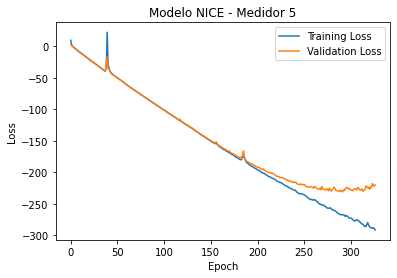

In [ ]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history5.history['loss']
val_accuracy = history5.history['val_loss']
np.save("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf5v2_history.npy", np.concatenate((train_accuracy,val_accuracy), axis = 0))
# Set figure size.
plt.figure()
# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Loss')
plt.plot(val_accuracy, label='Validation Loss')
# Set title
plt.title('Modelo NICE - Medidor 5')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf5v2.png", dpi=300)

Instancias decoder

In [ ]:
# Construir o modelo inverso (gerar o modelo) e realizar todas as operações 
# no sentido inverso

x = x_in
x = scale.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_4(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle4.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_3(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle3.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_2(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle2.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_1(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle1.inverse()(x)

decoder5 = Model(x_in, x)

Geração de amostras novas 

In [ ]:
n_amostras = int(x5_train.shape[0]*0.4)
output_size = 96
samples_x5 = np.zeros((n_amostras, 96))

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      samples_x5[i,:] = decoder5.predict(z_sample)

np.savetxt("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/new_transf5_40p.csv", samples_x5, delimiter=",")

Geração do número de amostras precisas para atingir 12000 amostras em total

In [ ]:
n_amostras = 15000-x5_train.shape[0]
output_size = 96
samples_x5 = np.zeros((n_amostras, 96))

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      samples_x5[i,:] = decoder5.predict(z_sample)

np.savetxt("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/new_transf5_15k.csv", samples_x5, delimiter=",")

## 4. Todos os transformadores

Instancias encoder

In [ ]:
shuffle1 = Shuffle()
shuffle2 = Shuffle()
shuffle3 = Shuffle()
shuffle4 = Shuffle()

split = SplitVector()
couple = AddCouple()
concat = ConcatVector()
scale = Scale()

original_dim = 96

basic_model_1 = build_basic_model(original_dim//2)
basic_model_2 = build_basic_model(original_dim//2)
basic_model_3 = build_basic_model(original_dim//2)
basic_model_4 = build_basic_model(original_dim//2)


x_in = Input(shape=(original_dim,))
x = x_in


# Adicione ruído negativo à entrada

x = Lambda(lambda s: K.in_train_phase(s-0.01*K.random_uniform(K.shape(s)), s))(x)

x = shuffle1(x)
x1,x2 = split(x)
mx1 = basic_model_1(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle2(x)
x1,x2 = split(x)
mx1 = basic_model_2(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle3(x)
x1,x2 = split(x)
mx1 = basic_model_3(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle4(x)
x1,x2 = split(x)
mx1 = basic_model_4(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = scale(x)

In [ ]:
encoder6 = Model(x_in, x)
encoder6.summary()
encoder6.compile(loss=lambda y_true, y_pred: K.sum(0.5 * y_pred**2, 1),
                optimizer='adam')

Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 96)           0           input_40[0][0]                   
__________________________________________________________________________________________________
shuffle_52 (Shuffle)            (None, 96)           0           lambda_13[0][0]                  
__________________________________________________________________________________________________
split_vector_31 (SplitVector)   [(None, 48), (None,  0           shuffle_52[0][0]                 
                                                                 shuffle_53[0][0]          

Treinamento do encoder

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf6.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history6 = encoder6.fit(X_train,
            X_train,
            batch_size=128,
            epochs=700,
            validation_data=(X_test, X_test), callbacks=[model_checkpoint_callback, early_stop_callback])

Epoch 1/700


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_45/shuffle_55/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_45/shuffle_55/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_45/shuffle_55/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_45/shuffle_54/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_45/shuffle_54/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_45/shuffle_54/Cast:0", shape=(2,), dtype=int32))) to a den

184/184 [==============================] - 3s 10ms/step - loss: -7.6736 - val_loss: -16.8650
Epoch 2/700
184/184 [==============================] - 1s 8ms/step - loss: -25.6114 - val_loss: -34.6611
Epoch 3/700
184/184 [==============================] - 1s 7ms/step - loss: -42.8443 - val_loss: -51.8873
Epoch 4/700
184/184 [==============================] - 1s 8ms/step - loss: -60.6849 - val_loss: -69.5359
Epoch 5/700
184/184 [==============================] - 2s 9ms/step - loss: -78.1270 - val_loss: -84.7748
Epoch 6/700
184/184 [==============================] - 2s 8ms/step - loss: -95.2621 - val_loss: -104.4131
Epoch 7/700
184/184 [==============================] - 2s 9ms/step - loss: -113.0508 - val_loss: -121.7172
Epoch 8/700
184/184 [==============================] - 1s 8ms/step - loss: -129.4518 - val_loss: -138.5112
Epoch 9/700
184/184 [==============================] - 1s 8ms/step - loss: -146.8564 - val_loss: -155.2173
Epoch 10/700
184/184 [==============================] - 1s 7

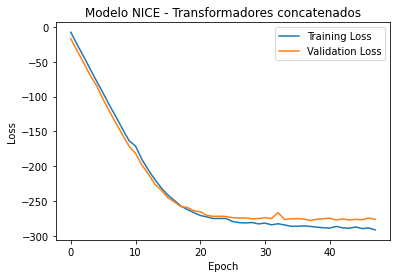

In [ ]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history6.history['loss']
val_accuracy = history6.history['val_loss']
np.save("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf6_history.npy", np.concatenate((train_accuracy,val_accuracy), axis = 0))
# Set figure size.
plt.figure()
# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Loss')
plt.plot(val_accuracy, label='Validation Loss')
# Set title
plt.title('Modelo NICE - Transformadores concatenados')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/transf6.png", dpi=300)

Instancias decoder

In [ ]:
# Construir o modelo inverso (gerar o modelo) e realizar todas as operações 
# no sentido inverso

x = x_in
x = scale.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_4(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle4.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_3(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle3.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_2(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle2.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_1(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle1.inverse()(x)

decoder6 = Model(x_in, x)

Geração de amostras novas 

In [ ]:
n_amostras = int(X_train.shape[0]*0.4)
output_size = 96
samples_x6 = np.zeros((n_amostras, 96))

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      samples_x6[i,:] = decoder6.predict(z_sample)

np.savetxt("/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/new_samples_final/new_transf6.csv", samples_x6, delimiter=",")